In [1]:
import pickle
import numpy as np
from ANEMO import ANEMO
from aSPEM import Analysis
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import glob
liste = {'pari':{}, 'enregistrement':{}}

for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste[a[0]][a[1]] = a[2]+'_'+a[3]

SUJETS = liste['pari'].keys() # ['BMC'] #
data, exp = {}, {}


import os
from ANEMO import read_edf
for s in SUJETS :
    with open('data/pari_%s_%s.pkl'%(s, liste['pari'][s]), 'rb') as fichier :
        exp[s] = pickle.load(fichier, encoding='latin1')
    
    resultats = os.path.join('data', 'enregistrement_' + s + '_' + liste['enregistrement'][s] + '.asc')
    data[s] = read_edf(resultats, 'TRIALID')

In [3]:
raw_size = {}
for s in SUJETS :
    raw_size[s] = []
    A = ANEMO(exp[s])
    N_blocks, N_trials = exp[s]['N_blocks'], exp[s]['N_trials']
    
    for block in range(N_blocks) :
    
        for trial in range(N_trials) :
            
            trial_data = trial + N_trials*block
            arg = A.arg(data[s][trial_data], trial=trial, block=block)
            
            taille = data[s][trial_data]['size']
            for sacc in arg.saccades : taille[sacc[0]-arg.t_0 -5 : sacc[1]-arg.t_0 +15] = np.nan
            raw_size[s].extend(list(taille))

DC TN CS IP LB YK RS AM 

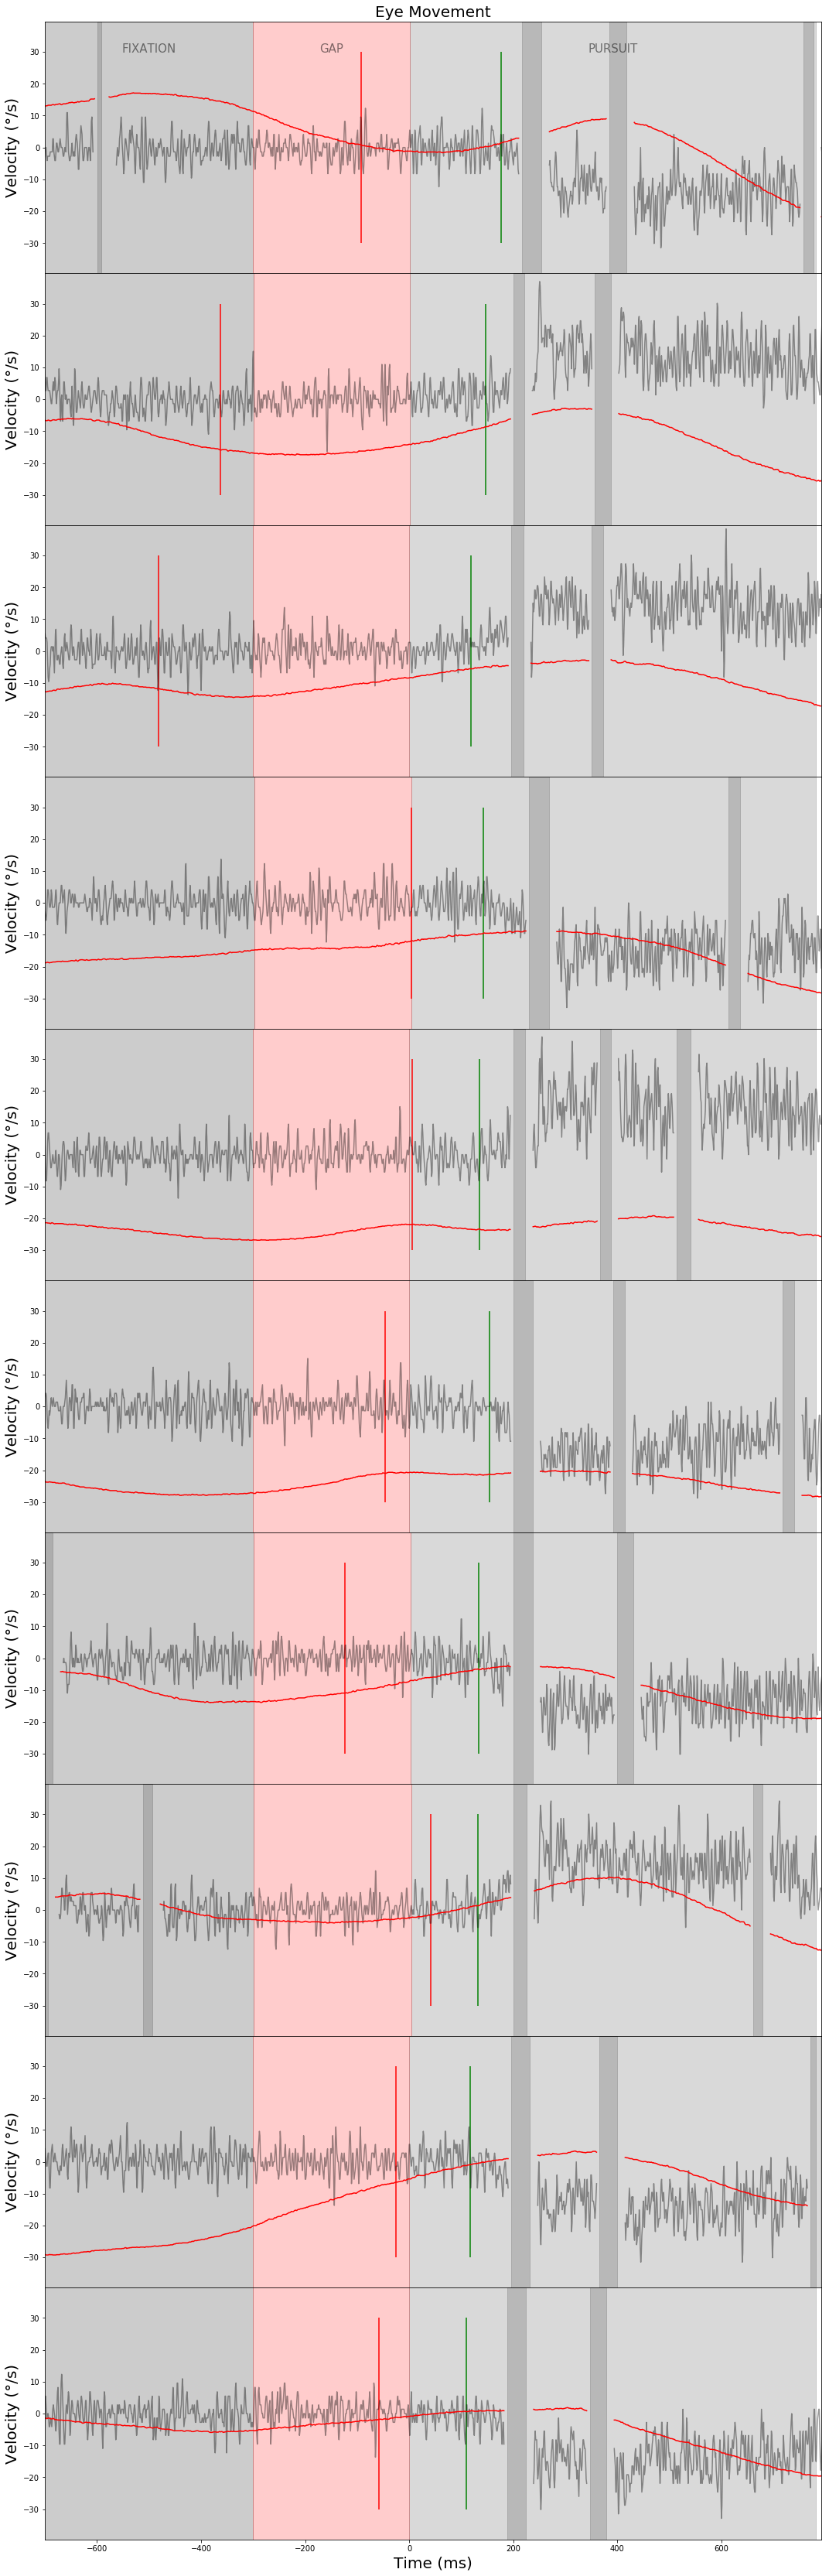

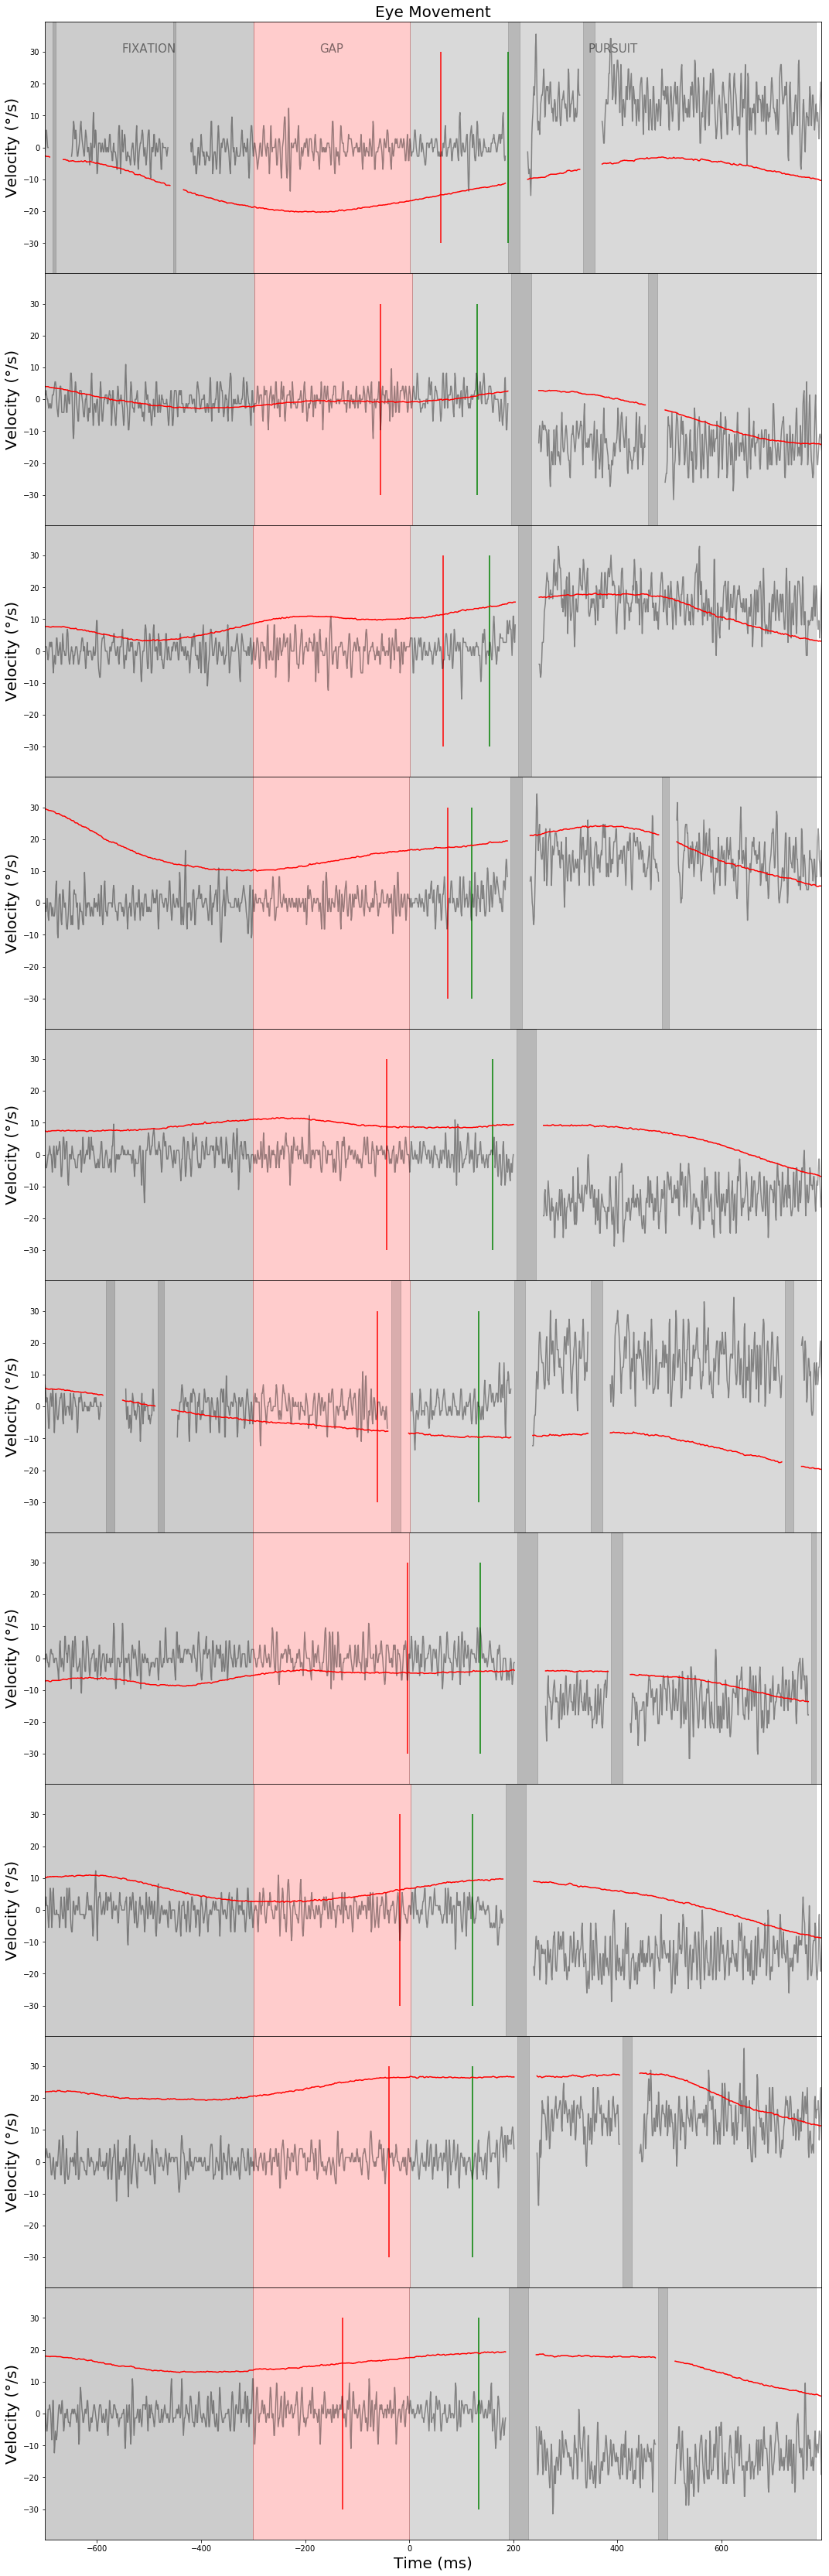

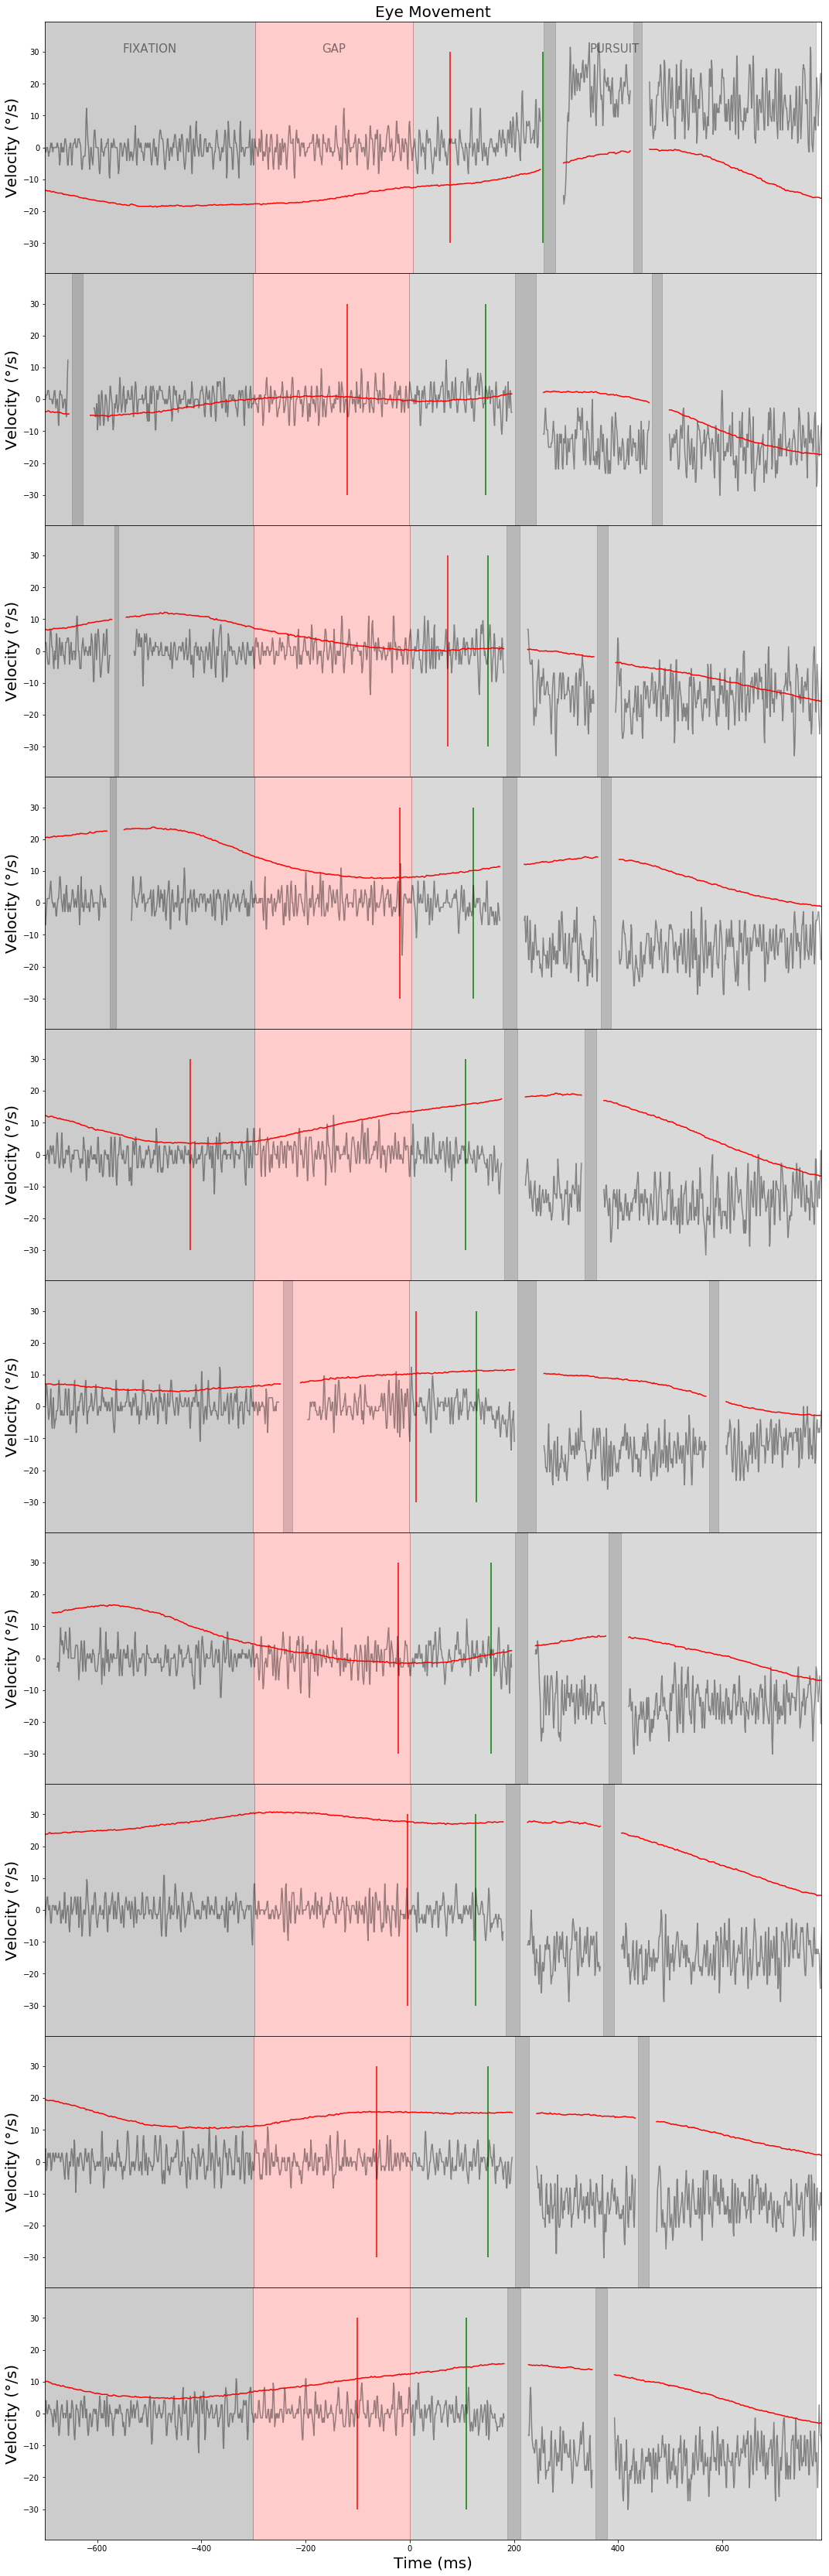

FM OP SR BMC 

In [4]:
fig_width = 15
t_label, t_text = 20, 14

size, size_anti, size_start_anti, size_latency = {}, {}, {}, {}
for swi in ['full', 'switch', 'noswitch'] :
    size[swi], size_anti[swi], size_start_anti[swi], size_latency[swi] = {}, {}, {}, {}

for s in SUJETS :
    print(s, end=' ')
    for swi in ['full', 'switch', 'noswitch'] :
        size[swi][s], size_anti[swi][s], size_start_anti[swi][s], size_latency[swi][s] = [], [], [], []
    
    e = Analysis(observer=s, name_file_fit='fct_velocity_sigmo')
    A = ANEMO(exp[s]) 
    N_blocks, N_trials = exp[s]['N_blocks'], exp[s]['N_trials']
    
    for block in range(N_blocks) :
        
        if s=='AM' : fig, ax = e.plot_data(trials=list(np.arange(10)), block=block)
        
        switch = np.where(exp[s]['p'][:, block, 2]==1)[0]
        
        for trial in range(N_trials) :
            trial_data = trial + N_trials*block
            arg = A.arg(data[s][trial_data], trial=trial, block=block)
            
            TarOn_0 = arg.TargetOn-arg.t_0
            start = TarOn_0-700
            stop = TarOn_0+800
            tps = arg.trackertime[start:stop]-arg.TargetOn
            
            start_anti = e.ENREGISTREMENT[s]['start_anti'][block][trial]
            latency = e.ENREGISTREMENT[s]['latency'][block][trial]
            
            taille = data[s][trial_data]['size']
            for sacc in arg.saccades : taille[sacc[0]-arg.t_0 -5:sacc[1]-arg.t_0 +15] = np.nan
                            
            taille_anti = taille[int(start_anti):int(latency)]
            if len(taille_anti) != 0 : size_anti['full'][s].append(taille_anti)
            
            taille_start_anti = taille[int(start_anti)+TarOn_0-200:int(start_anti)+TarOn_0+200]
            if len(taille_start_anti) != 0 : size_start_anti['full'][s].append(taille_start_anti)
            
            taille_latency = taille[int(latency)+TarOn_0-200:int(latency)+TarOn_0+200]
            if len(taille_latency) != 0 : size_latency['full'][s].append(taille_latency)
            
            taille = taille[start:stop]
            if len(taille) != 0 : size['full'][s].append(taille)  
            
            swiswi=False
            
            for sw in switch :
                if trial in np.arange(sw+2, sw+7) :
                    #print(trial)
                    swiswi=True
                    if len(taille) != 0 :            size['switch'][s].append(taille)
                    if len(taille_anti) != 0 :       size_anti['switch'][s].append(taille_anti)
                    if len(taille_start_anti) != 0 : size_start_anti['switch'][s].append(taille_start_anti)
                    if len(taille_latency) != 0 :    size_latency['switch'][s].append(taille_latency)
            
            if swiswi is False :
                if len(taille) != 0 :            size['noswitch'][s].append(taille)
                if len(taille_anti) != 0 :       size_anti['noswitch'][s].append(taille_anti)
                if len(taille_start_anti) != 0 : size_start_anti['noswitch'][s].append(taille_start_anti)
                if len(taille_latency) != 0 :    size_latency['noswitch'][s].append(taille_latency)

                    
            if s=='AM' and trial<10 :
                ax[trial].plot(tps, 100*(taille/np.nanmean(raw_size[s])) - 100, c='r' )
                ax[trial].vlines(start_anti, -30, 30, color='r')
                ax[trial].vlines(latency,    -30, 30, color='g')

        if s=='AM' : plt.show()

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice


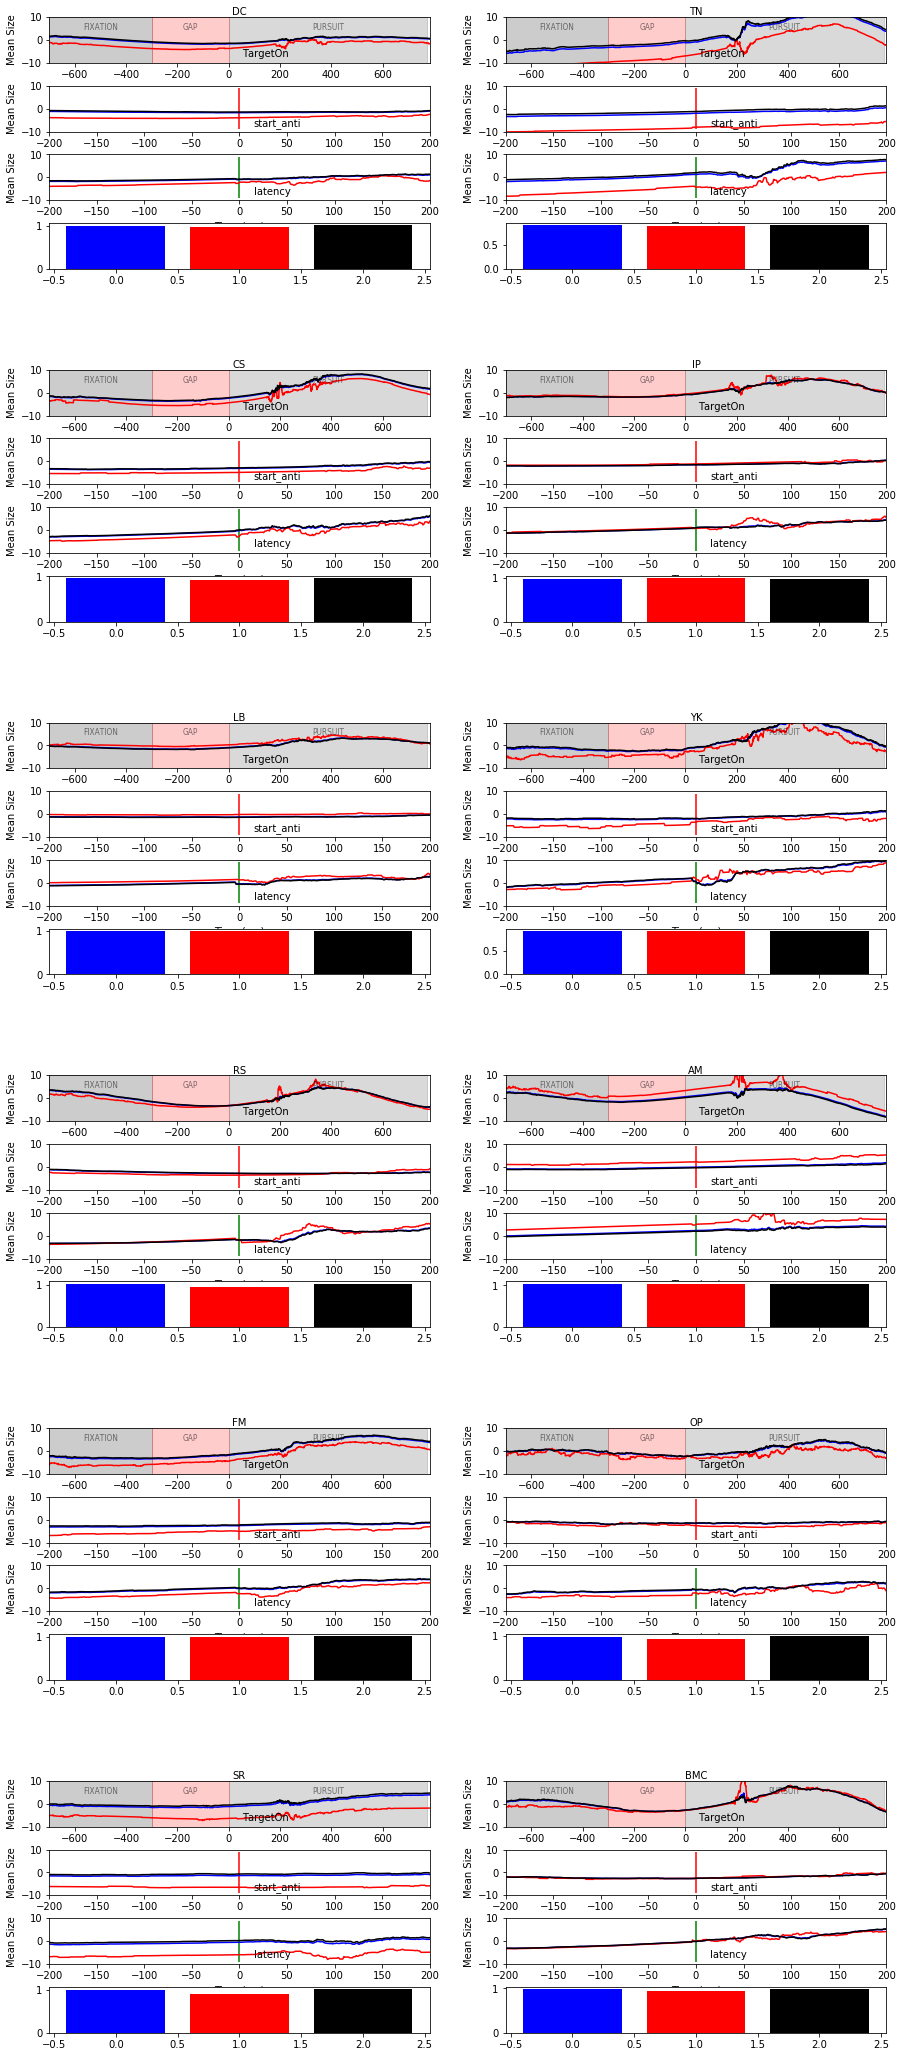

In [5]:
fig_width=15
t_label, t_text = 20/2, 14/2
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(fig_width, 8*(fig_width*(1/2))/1.6180))
axs = gridspec.GridSpec(6, 2, figure=fig, wspace=0.2, hspace=0.4)

N_cols=2

for i, s in enumerate(SUJETS) :
    #a, b = i // N_cols, i % N_cols
    #print(b, a)
    
    grid = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=axs[i], hspace=0.5)#, wspace=0.15)
    ax_0 = fig.add_subplot(grid[0])
    ax_1 = fig.add_subplot(grid[1])
    ax_2 = fig.add_subplot(grid[2])
    ax_3 = fig.add_subplot(grid[3])
    
    
    #fig.subplots_adjust(hspace=0.2)
    
    start = arg.TargetOn
    time_s = arg.trackertime-start
    TarOn_s, TarOff_s  = arg.TargetOn-start,   arg.TargetOff-start
    StimOn_s, StimOf_s = arg.StimulusOn-start, arg.StimulusOf - start

    onset = arg.TargetOn-arg.t_0
    start, stop = onset-700, onset+800
    tps = time_s[start:stop]
    tps_anti = np.linspace(-200, 200, len(size_start_anti['full'][s][0]))
    
    
    opt = dict(fontsize=t_label, color='k')
    ax_0.set_title(s, y=0.91, **opt)
    ax_0.text(50, -7.5, 'TargetOn',   **opt)
    ax_1.text(15,  -7.5, 'start_anti', **opt)
    ax_2.text(15,  -7.5, 'latency',    **opt)
    
    for a in [ax_0, ax_1, ax_2] :
        a.set_ylabel('Mean Size', **opt)
    ax_2.set_xlabel('Time (ms)', **opt)
    
    #----------------------------------------------------------------------
    ax_0.axvspan(StimOn_s, StimOf_s, color='k', alpha=0.2)
    ax_0.axvspan(StimOf_s, TarOn_s,  color='r', alpha=0.2)
    ax_0.axvspan(TarOn_s,  TarOff_s, color='k', alpha=0.15)

    opt = dict(color='k', size=t_label*.75, ha='center', va='top', alpha=0.5)
    ax_0.text(StimOf_s+(TarOn_s-StimOf_s)/2,            7.5, "GAP",      **opt)
    ax_0.text((TarOn_s-700)+(StimOf_s-(TarOn_s-700))/2, 7.5, "FIXATION", **opt)
    ax_0.text(TarOn_s+(TarOff_s-TarOn_s)/2,             7.5, "PURSUIT",  **opt)
    #----------------------------------------------------------------------
    
    for sisi, c, i in zip(['full', 'switch', 'noswitch'], ['b', 'r', 'k'], [0,1,2]) :
        ax_0.plot(tps,      100*np.nanmean((size[sisi][s]/np.nanmean(raw_size[s])), axis=0)-100,            c=c)
        ax_1.plot(tps_anti, 100*np.nanmean((size_start_anti[sisi][s]/np.nanmean(raw_size[s])), axis=0)-100, c=c)
        ax_2.plot(tps_anti, 100*np.nanmean((size_latency[sisi][s]/np.nanmean(raw_size[s])), axis=0)-100,    c=c)

        lala = [np.nanmean(np.nanmean(size_anti[sisi][s][t]))/np.nanmean(raw_size[s]) for t in range(len(size_anti[sisi][s]))]
        ax_3.bar(i, np.nanmean(lala),    color=c)
        
    ax_0.axis([TarOn_s-700, TarOff_s+10, -10, 10])
    for a, c in zip([ax_1, ax_2], ['r', 'g']) :
        a.axis([-200, 200, -10, 10])
        a.vlines(0, -9, 9, color=c)

plt.show()